# 4.0 Data Cleaning and Collection
With our ResNet-50 model constructed. Data are required to train our model so that we can classify our pictures into "Dog", "Cat", or neither. We will work through by first sourcing the data, then we would rescale it, and finally, convert it into a suitable `DataLoader` class.

## 4.1 Data Sourcing
Kaggle is a great site to find datasets and even test your model on them to compare it to others. We will use this [Kaggle dataset for dogs and cats classification](https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset/data).

Let's export the kaggle dataset into `data/raw`

In [ ]:
from zipfile import ZipFile
import os
import shutil
import matplotlib.pyplot as plt
import random
import cv2
import json 
from torch.utils.data import Dataset, DataLoader
import torch

In [21]:
!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset -p ../data/raw

^C


With the dataset downloaded, then we unzip it.

In [23]:
raw_folder = '../data/raw'

def extract_data(folder):
    zip_file_path = os.path.join(folder, 'dog-and-cat-classification-dataset.zip')
    extract_to_path = folder

    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)

    # Move files from PetImages to the raw_folder
    source_dir = os.path.join(folder, 'PetImages')
    for item in os.listdir(source_dir):
        source_item_path = os.path.join(source_dir, item)
        destination_item_path = os.path.join(folder, item)
        shutil.move(source_item_path, destination_item_path)

    os.rmdir(source_dir)

extract_data(raw_folder)


With the image dataset exported to our raw folder. Let's load them into our notebook.

In [25]:
def load_raw_images():
    raw_cat_images = []
    raw_dog_images = []
    
    for filename in os.listdir(raw_folder + '/Cat'):
        img = cv2.imread(raw_folder + '/Cat/' + filename)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        raw_cat_images.append(img)
        
    for filename in os.listdir(raw_folder + '/Dog'):
        img = cv2.imread(raw_folder + '/Dog/' + filename)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
        raw_dog_images.append(img)
        
    return (raw_cat_images, raw_dog_images)

In [4]:
raw_cat_images, raw_dog_images = load_raw_images()

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


With the raw images loaded, let's build a function to visualize it. It'll be super cute!

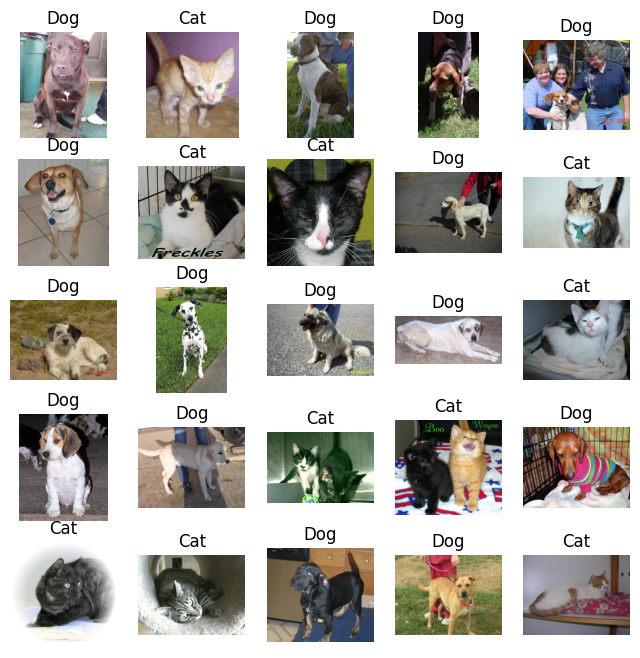

In [5]:
def visualize_raw_pet_images(cat_images, dog_images):
    _, ax = plt.subplots(5, 5, figsize=(8, 8))
    for i in range(5):
        for j in range(5):
            is_cat = random.randint(0, 1)
            cat_images_len = len(cat_images)
            dog_images_len = len(dog_images)
            
            label = "Cat" if is_cat else "Dog"
            
            ax[i, j].imshow(cat_images[random.randint(0, cat_images_len - 1)] if is_cat
                            else dog_images[random.randint(0, dog_images_len - 1)])
            ax[i, j].axis("off")
            ax[i, j].set_title(label)
visualize_raw_pet_images(raw_cat_images, raw_dog_images)

Cute huh! We now move to processing it.

## 4.2 Data Processing
The standard defacto image size of ML/AI is 224x224 (even in our ResNet paper!). We should resize everything to 224x224, and then save it to `data/processed`. Here we implement an image processing function

In [ ]:
def process_image (img, filename, dimension=(224, 224)):
    resized_image = cv2.resize(img, dimension, cv2.INTER_AREA)
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)

    cv2.imwrite(filename, resized_image)
    
def process_raw_images(images, label, folderpath, counter=0, dimension=(224, 224)):
    for i, img in enumerate(images):
        process_image(img, folderpath + f"/{counter}-{label}.jpg", dimension)
        counter += 1
    return counter
def save_metadata(metadata, outpath="../data/processed/metadata.json"):
    with open(outpath, "w") as f:
        json.dump(metadata, f, indent=4)

In [ ]:
total_cats = process_raw_images(raw_cat_images, "cat", "../data/processed")
total_imgs = process_raw_images(raw_dog_images, "dog", "../data/processed", total_cats)

metadata = {
    "num_images": total_imgs,
    "dimension": [224, 224],
    "format": "jpg"
}

save_metadata(metadata) 

## 4.3 Cat and Dog Dataset
Let's implement a `Dataset` and `DataLoader` class to get images from our `data/processed` folder.

In [ ]:
class CatAndDogDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        with open(img_dir + "/metadata.json", "r") as f:
            metadata = json.load(f)
        self.metadata = metadata
        self.img_dir = img_dir
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")],
                                key=lambda x: int(x.split('-')[0])) # Sort files by their numerical ID
        
        self.transform = transform
        self.target_transform = target_transform
        self.class_map = {"cat": 0, "dog": 1}
    
    def __len__(self):
        return self.metadata['num_images']
    
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # load image with cv2
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV loads BGR
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        
        # parse label from filename ("1-cat.jpg" -> "cat")
        label_str = img_name.split("-")[1].split(".")[0]  # "cat" or "dog"
        label = self.class_map[label_str]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

Let's use a `DataLoader` to retrieve our processed data now, all the images should be 224x224, and it should come with its label automatically.

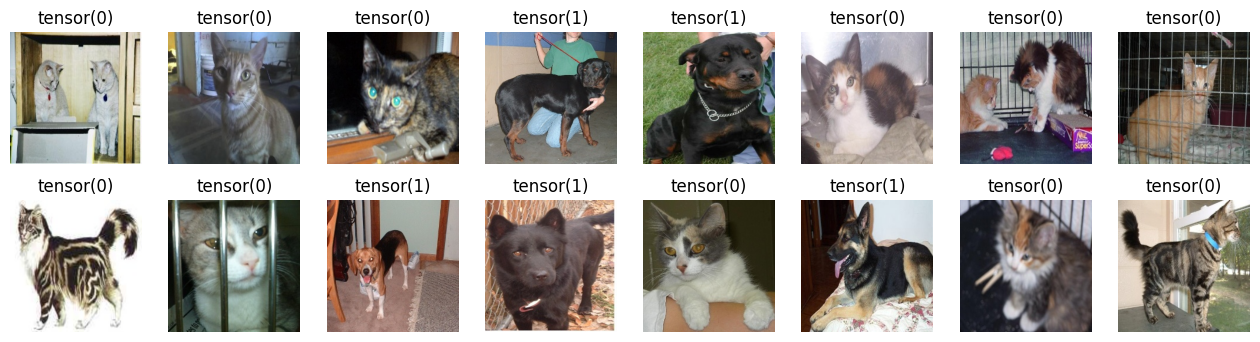

In [18]:
def visualize_pet_images(images, labels):
    _, ax = plt.subplots(2, 8, figsize=(16, 4))
    img_idx = 0
    for i in range(2):
        for j in range(8):    
            ax[i, j].imshow(images[img_idx])
            ax[i, j].axis("off")
            ax[i, j].set_title(labels[img_idx])
            img_idx += 1

dataset = CatAndDogDataset("../data/processed")
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
images, labels = next(iter(dataloader))
visualize_pet_images(images, labels)


We are finally done. Here we go to the most exciting part!